In [1]:
%load_ext autoreload
%autoreload 2

from utils import *
from dual import *

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
data_airline = pd.read_csv('airline_data.csv').dropna().sample(500)

data_size = len(data_airline.index)

air_X = data_airline.iloc[:, :-1]
air_y = data_airline.iloc[:, -1]

sat_encoder = LabelEncoder()
air_y = np.array(sat_encoder.fit_transform(air_y))
air_y = air_y * 2 - 1

air_X['Gender'] = sat_encoder.fit_transform(air_X.Gender.values)
air_X['Customer Type'] = sat_encoder.fit_transform(air_X['Customer Type'].values)
air_X['Type of Travel'] = sat_encoder.fit_transform(air_X['Type of Travel'].values)
air_X['Class'] = sat_encoder.fit_transform(air_X['Class'].values)

air_X = air_X.drop(labels=["Unnamed: 0"], axis=1)
air_X = air_X.drop(labels=["id"], axis=1)

#air_X = air_X[['Flight Distance',
#       'Arrival Delay in Minutes']]

scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(air_X)
air_X = np.array(scaler.transform(air_X))

#air_X = air_X[:,0:12]


In [3]:
def voice_prep(data, features):
      
    data_size = len(data.index)

    voice_X = data.iloc[:, :-1]
    voice_y = data.iloc[:, -1]

    # code categories to -1/1
    gender_encoder = LabelEncoder()
    voice_y = np.array(gender_encoder.fit_transform(voice_y))
    voice_y = voice_y * 2 - 1

    # normalize data
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler.fit(voice_X)
    voice_X = np.array(scaler.transform(voice_X))
    voice_X = voice_X[:,0:features]
    
    return voice_X, voice_y

voice_shuffle = load_file('voice_numsamp_shuffle_full').sample(1000)
voice_X, voice_y = voice_prep(voice_shuffle, 2)


In [4]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X, X_test, Y, y_test = train_test_split(voice_X, voice_y, test_size=0.33, random_state=42)


In [5]:
X

array([[ 0.86364932, -0.73412906],
       [ 0.1933676 , -0.10871619],
       [ 0.4295356 , -0.68829192],
       ...,
       [ 0.3750735 , -0.60534666],
       [ 0.36449002, -0.25856572],
       [-0.11370121,  0.28120513]])

In [5]:
m = X.shape[0]
n = X.shape[1]
TEST = X_test.shape[0]
Y = Y.reshape(m,1)

In [10]:
# Form SVM with L1 regularization problem.
import cvxpy as cp
beta = cp.Variable((n,1))
#v = cp.Variable()

xis = []
for i in range(m):
    xis.append(cp.Variable())

rho = cp.Parameter(nonneg=True)

loss = cp.sum(xis)

constraints = [ cp.norm(beta) <= 1/cp.sqrt(rho) ]
for i in range(m):
    constraints += [xis[i] >= 0]
for i in range(m):
    constraints += [cp.multiply(Y, X @ beta) >= 1 - xis[i]]

prob = cp.Problem(cp.Minimize(loss), constraints)

In [18]:
# Form SVM with L1 regularization problem.
import cvxpy as cp
beta = cp.Variable((n,1))
v = cp.Variable()
rho = cp.Parameter(nonneg=True)
constraints = [ cp.norm(beta) <= 2/cp.sqrt(rho) ]

loss = cp.sum(cp.pos(rho - cp.multiply(Y, X @ beta - v)))

prob = cp.Problem(cp.Minimize(loss/m), constraints)

In [11]:
# Compute a trade-off curve and record train and test error.
rho_vals = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0 ] # np.linspace(1e-12, 3, TRIALS)

TRIALS = len(rho_vals)
train_error = np.zeros(TRIALS)
test_error = np.zeros(TRIALS)


inter_vals = []
beta_vals = []
models = []
for i in range(TRIALS):
    print(i, end='/')
    rho.value = rho_vals[i]
    prob.solve()
    train_error[i] = (Y != np.sign(X.dot(beta.value) - v.value)).sum()/m
    test_error[i] = (y_test != np.sign(X_test.dot(beta.value) - v.value).flatten()).sum()/TEST
    print(train_error[i], test_error[i], rho.value, cp.norm(beta).value, sep='\t')
    
    model = np.concatenate((np.array([float(v.value)]), beta.value.flatten(), np.array([float(rho.value)])))
    models.append(model)
    
    beta_vals.append(beta.value)
    inter_vals.append(v.value)

0/

D:\ANACONDA\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:164: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


0.41492537313432837	0.4090909090909091	0.5	1.0644399948279464e-14
1/0.1761194029850746	0.19090909090909092	0.75	1.3465937033409835e-15
2/0.41194029850746267	0.403030303030303	1.0	1.1115120158069365e-14
3/0.4208955223880597	0.403030303030303	1.25	6.526232063771498e-15
4/0.41940298507462687	0.3939393939393939	1.5	5.9371964008597694e-15
5/0.41940298507462687	0.396969696969697	1.75	6.3010961021343804e-15
6/0.27761194029850744	0.2515151515151515	2.0	2.162274387041627e-15


In [10]:
len(X)

670

In [11]:
models[3]

array([-0.17347173, -0.45391692,  0.89104401,  0.75      ])

In [ ]:
for i in range(8):
    plot_predicts(models[i], X, Y, radvec=None, model_type="fixed_svm")

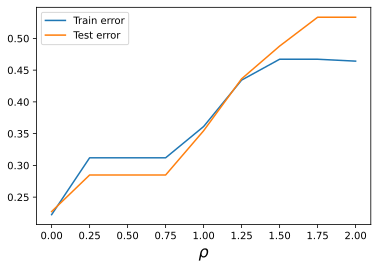

In [24]:
# Plot the train and test error over the trade-off curve.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.plot(rho_vals, train_error, label="Train error")
plt.plot(rho_vals, test_error, label="Test error")
#plt.xscale('lin')
plt.legend(loc='upper left')
plt.xlabel(r"$\rho$", fontsize=16)
plt.show()

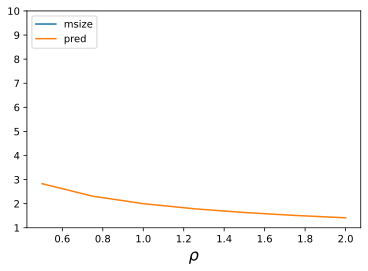

In [9]:
# Plot the train and test error over the trade-off curve.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

margin_sizes = [(2 / np.linalg.norm(beta)) for beta in beta_vals]
plt.ylim(1,10)
plt.plot(rho_vals, margin_sizes, label="msize")
plt.plot(rho_vals, 2 / np.sqrt(rho_vals), label="pred")
# plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel(r"$\rho$", fontsize=16)
plt.show()

In [94]:
margin_sizes

[718052561064361.2,
 6.234059790923394,
 3.1170298954638764,
 2.078019930307903,
 2.000000000000401,
 2.0000000000085905,
 2.0000000001444427,
 2.000000000017866,
 2.0000000000566813]

In [77]:
# Form SVM with L1 regularization problem.
import cvxpy as cp
beta = cp.Variable((n,1))
v = cp.Variable()
loss = cp.sum(cp.pos(1 - cp.multiply(Y, X @ beta - v)))
reg = cp.norm(beta, 1)
lambd = cp.Parameter(nonneg=True)
prob = cp.Problem(cp.Minimize(loss/m + lambd*reg))

In [78]:
# Compute a trade-off curve and record train and test error.
TRIALS = 100
train_error = np.zeros(TRIALS)
test_error = np.zeros(TRIALS)
lambda_vals = np.logspace(-2, 0, TRIALS)
beta_vals = []
for i in range(TRIALS):
    lambd.value = lambda_vals[i]
    prob.solve()
    train_error[i] = (Y != np.sign(X.dot(beta.value) - v.value)).sum()/m
    test_error[i] = (y_test != np.sign(X_test.dot(beta.value) - v.value).flatten()).sum()/TEST
    beta_vals.append(beta.value)

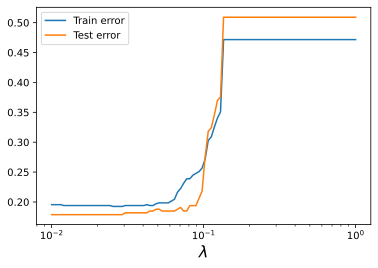

In [79]:
# Plot the train and test error over the trade-off curve.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.plot(lambda_vals, train_error, label="Train error")
plt.plot(lambda_vals, test_error, label="Test error")
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel(r"$\lambda$", fontsize=16)
plt.show()

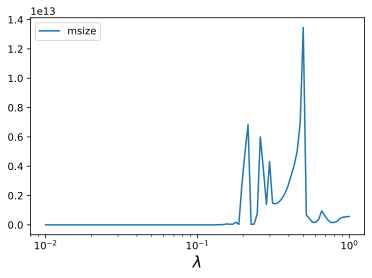

In [84]:
# Plot the train and test error over the trade-off curve.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

margin_sizes = [(2 / np.linalg.norm(beta)) for beta in beta_vals]

plt.plot(lambda_vals, margin_sizes, label="msize")
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel(r"$\lambda$", fontsize=16)
plt.show()